# EDA

In [45]:
# load libraries
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
import time
start_time = time.time()

In [46]:
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

In [47]:
listings_large_1_df = pd.read_csv("data/LA_2022.10-12/listings.csv.gz")
listings_large_2_df = pd.read_csv("data/LA_2023.1-3/listings.csv.gz")
listings_large_3_df = pd.read_csv("data/LA_2023.4-6/listings.csv.gz")
listings_large_4_df = pd.read_csv("data/LA_2023.7-9/listings.csv.gz")


listings_large_combined_df = pd.concat(
    [listings_large_1_df, listings_large_2_df, listings_large_3_df, listings_large_4_df],
    ignore_index=True
)

listings_large_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171947 entries, 0 to 171946
Data columns (total 75 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            171947 non-null  int64  
 1   listing_url                                   171947 non-null  object 
 2   scrape_id                                     171947 non-null  int64  
 3   last_scraped                                  171947 non-null  object 
 4   source                                        171947 non-null  object 
 5   name                                          171943 non-null  object 
 6   description                                   169104 non-null  object 
 7   neighborhood_overview                         99737 non-null   object 
 8   picture_url                                   171947 non-null  object 
 9   host_id                                       17

In [48]:
reviews_large_1_df = pd.read_csv("data/LA_2022.10-12/reviews.csv.gz")
reviews_large_2_df = pd.read_csv("data/LA_2023.1-3/reviews.csv.gz")
reviews_large_3_df = pd.read_csv("data/LA_2023.4-6/reviews.csv.gz")
reviews_large_4_df = pd.read_csv("data/LA_2023.7-9/reviews.csv.gz")

reviews_large_combined_df = pd.concat(
    [reviews_large_1_df, reviews_large_2_df, reviews_large_3_df, reviews_large_4_df],
    ignore_index=True
)

reviews_large_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5748175 entries, 0 to 5748174
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   listing_id     int64 
 1   id             int64 
 2   date           object
 3   reviewer_id    int64 
 4   reviewer_name  object
 5   comments       object
dtypes: int64(3), object(3)
memory usage: 263.1+ MB


In [49]:
# 1) Compute composite success score
listings = listings_large_combined_df.copy()
listings['success_score'] = (
    listings['review_scores_rating']
    * np.log1p(listings['number_of_reviews'])
)

# 2) Keep only listings with ≥ 10 reviews
filtered = listings[listings['number_of_reviews'] >= 10]

# 3) Pick top X% (here, 10%) by success_score
pct = 0.10
n   = int(len(filtered) * pct)

top_listings_df = (
    filtered
    .sort_values('success_score', ascending=False)
    .head(n)
    [['id','name','neighbourhood_cleansed',
      'price','number_of_reviews',
      'review_scores_rating',
      'success_score']]
)

In [50]:
df = listings_large_combined_df.copy()

df['price'] = df['price'].str.replace('[\$,]', '', regex=True).astype(float)

df['host_since'] = pd.to_datetime(df['host_since'])
df['host_experience_days'] = (datetime.now() - df['host_since']).dt.days

df['amenities_count'] = df['amenities'].str.split(',').apply(len)

df['is_superhost'] = df['host_is_superhost'] == 't'
df['instant_bookable'] = df['instant_bookable'] == 't'

In [51]:
top_ids = set(top_listings_df['id'])
df['is_top'] = df['id'].isin(top_ids)

In [52]:
features = [
    'price', 'accommodates', 'bedrooms', 'beds',
    'host_experience_days', 'amenities_count'
]

summary = df.groupby('is_top')[features].agg(['mean', 'median'])
print(summary)

             price        accommodates         bedrooms             beds  \
              mean median         mean median      mean median      mean   
is_top                                                                     
False   288.575095  147.0     3.943964    3.0  1.921404    1.0  2.180967   
True    176.063011  138.0     3.292588    2.0  1.474069    1.0  1.821782   

              host_experience_days         amenities_count         
       median                 mean  median            mean median  
is_top                                                             
False     2.0          2885.448876  3022.0       35.163784   33.0  
True      1.0          3676.567326  3678.0       41.152632   39.0  


In [53]:
for col in ['room_type', 'property_type', 'is_superhost', 'instant_bookable']:
    ct = pd.crosstab(df[col], df['is_top'], normalize='columns').rename(columns={False: 'all_others', True: 'top'})
    print(f"\nfeature: {col}\n", ct.sort_values('top', ascending=False).head())


feature: room_type
 is_top           all_others       top
room_type                            
Entire home/apt    0.705126  0.763291
Private room       0.274949  0.234252
Shared room        0.018031  0.001940
Hotel room         0.001894  0.000517

feature: property_type
 is_top                all_others       top
property_type                             
Entire guesthouse       0.048990  0.198034
Entire home             0.231573  0.194412
Private room in home    0.151295  0.139956
Entire rental unit      0.256638  0.118484
Entire guest suite      0.026605  0.114474

feature: is_superhost
 is_top        all_others       top
is_superhost                      
True             0.28049  0.703402
False            0.71951  0.296598

feature: instant_bookable
 is_top            all_others       top
instant_bookable                      
False               0.711837  0.771698
True                0.288163  0.228302


In [54]:
tstat, pval = ttest_ind(
    df.loc[df['is_top'], 'price'],
    df.loc[~df['is_top'], 'price'],
    equal_var=False
)
print("price t‑test p‑value:", pval)

ct = pd.crosstab(df['is_superhost'], df['is_top'])
chi2, pval, _, _ = chi2_contingency(ct)
print("superhost chi2 p‑value:", pval)

price t‑test p‑value: 6.337737769762366e-180
superhost chi2 p‑value: 0.0


Note: low p-values represent statistical significance.

**Occuapancy Rate: (30−availability_30)/30**

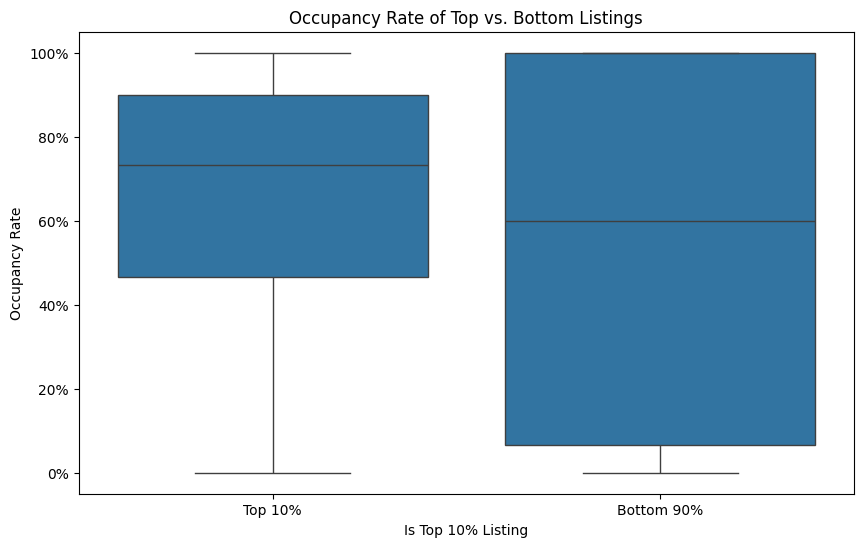

Occupancy Rate t-test p-value: 9.651132037879455e-264 

            min       25%       50%  75%  max       IQR
is_top_2                                               
Bottom 90%  0.0  0.066667  0.600000  1.0  1.0  0.933333
Top 10%     0.0  0.466667  0.733333  0.9  1.0  0.433333


In [64]:
# prompt: Calculate occupancy rate as "30−availability_30)/30. I want to use this as way to prove that successufull listings have higher occupancy rate. Try to tunr this into some sort of visualization.

# Calculate occupancy rate
df['occupancy_rate'] = (30 - df['availability_30']) / 30

df['is_top_2'] = df['is_top'].map({True: 'Top 10%', False: 'Bottom 90%'})

# Create the visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_top_2', y='occupancy_rate', data=df,
            order=['Top 10%', 'Bottom 90%'])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title('Occupancy Rate of Top vs. Bottom Listings')
plt.xlabel(f"Is Top 10% Listing")
plt.ylabel('Occupancy Rate')
plt.savefig(f"{output_dir}/occupancy_rate_boxplot.png")
plt.show()

# Perform t-test to compare occupancy rates
tstat, pval = ttest_ind(
    df.loc[df['is_top'], 'occupancy_rate'],
    df.loc[~df['is_top'], 'occupancy_rate'],
    equal_var=False
)
print("Occupancy Rate t-test p-value:", pval, "\n")

summary = df.groupby('is_top_2')['occupancy_rate'].describe()
summary['IQR'] = summary['75%'] - summary['25%']
print(summary[['min', '25%', '50%', '75%', 'max', 'IQR']])

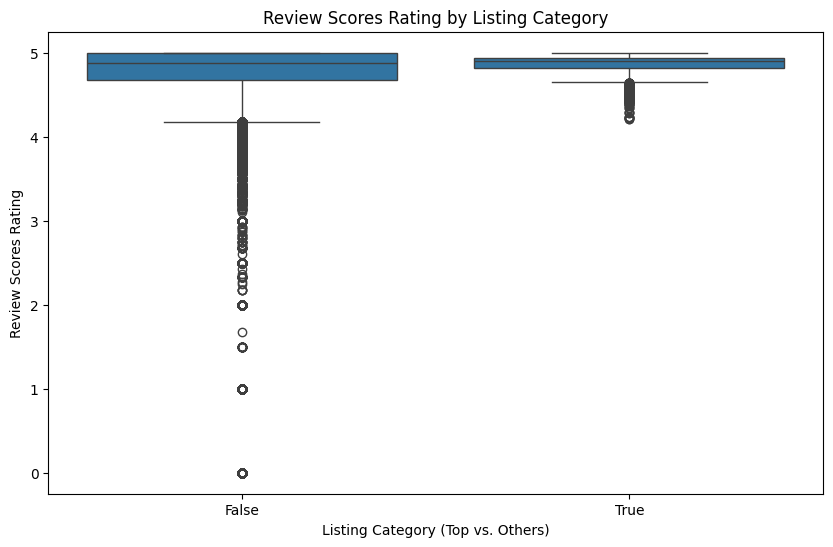

Review Scores Rating t-test p-value: nan


In [ ]:
# prompt: Similar to above, generate a visualization for ratings i.e. review_scores_rating

# Create the visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_top', y='review_scores_rating', data=df)
plt.title('Review Scores Rating by Listing Category')
plt.xlabel('Listing Category (Top vs. Others)')
plt.ylabel('Review Scores Rating')
plt.savefig(f"{output_dir}/review_scores_rating_boxplot.png")
plt.show()

# Perform t-test to compare review scores
tstat, pval = ttest_ind(
    df.loc[df['is_top'], 'review_scores_rating'],
    df.loc[~df['is_top'], 'review_scores_rating'],
    equal_var=False
)
print("Review Scores Rating t-test p-value:", pval)




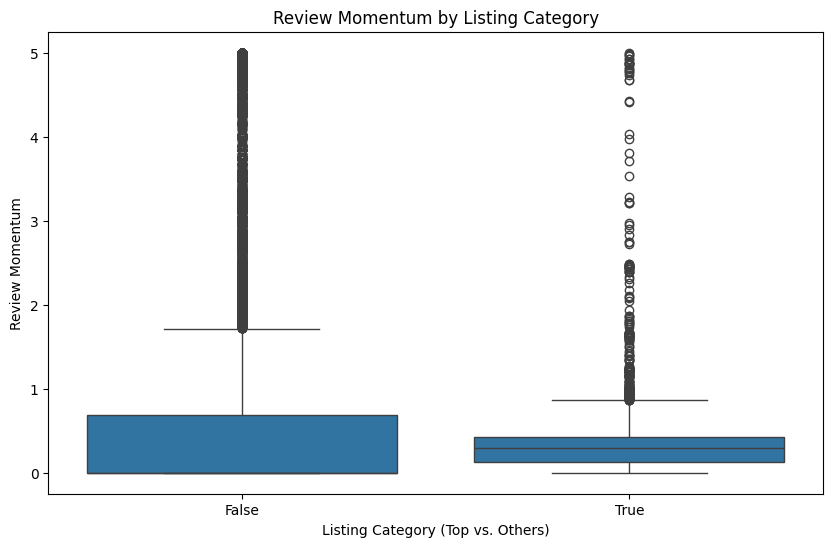

Review Momentum t-test p-value: nan


In [57]:
# prompt: I am trying to claculte review mometum as ((number_of_reviews_l30d/number_of_reviews_ltm)*review_scores_rating). Plot visualization for that

# Calculate review momentum
df['review_momentum'] = (df['number_of_reviews_l30d'] / df['number_of_reviews_ltm']) * df['review_scores_rating']

# Create the visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_top', y='review_momentum', data=df)
plt.title('Review Momentum by Listing Category')
plt.xlabel('Listing Category (Top vs. Others)')
plt.ylabel('Review Momentum')
plt.savefig(f"{output_dir}/review_momentum_boxplot.png")
plt.show()

# Perform t-test to compare review momentum
tstat, pval = ttest_ind(
    df.loc[df['is_top'], 'review_momentum'],
    df.loc[~df['is_top'], 'review_momentum'],
    equal_var=False
)
print("Review Momentum t-test p-value:", pval)


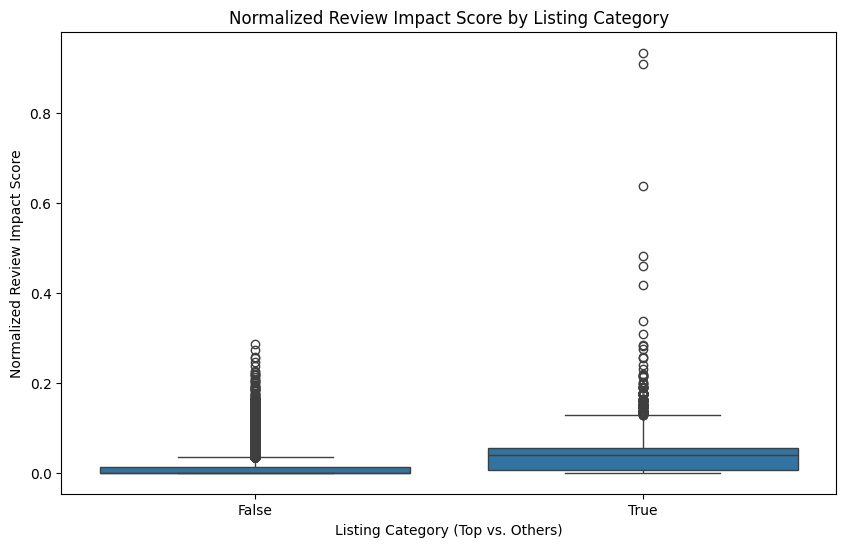

Normalized Review Impact Score t-test p-value: nan


In [58]:
# prompt: Generate a visualization for: Normalized Review Impact Score
# (Number of reviews in last 30 days / max number of reviews in last 30 days)*(review score ratings / 5)

# Calculate Normalized Review Impact Score
df['normalized_review_impact'] = (df['number_of_reviews_l30d'] / df['number_of_reviews_l30d'].max()) * (df['review_scores_rating'] / 5)

# Create the visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_top', y='normalized_review_impact', data=df)
plt.title('Normalized Review Impact Score by Listing Category')
plt.xlabel('Listing Category (Top vs. Others)')
plt.ylabel('Normalized Review Impact Score')
plt.savefig(f"{output_dir}/normalized_review_impact_boxplot.png")
plt.show()

# Perform t-test to compare normalized review impact
tstat, pval = ttest_ind(
    df.loc[df['is_top'], 'normalized_review_impact'],
    df.loc[~df['is_top'], 'normalized_review_impact'],
    equal_var=False
)
print("Normalized Review Impact Score t-test p-value:", pval)


In [59]:
end_time = time.time()
print("total notebook execution time: {:.0f} seconds".format(end_time - start_time))

total notebook execution time: 25 seconds
